In [1]:
#install transformer
!git clone https://github.com/huggingface/transformers.git
%cd transformers
!pip3 install --upgrade .
%cd ../

Cloning into 'transformers'...
remote: Enumerating objects: 57703, done.
remote: Total 57703 (delta 0), reused 0 (delta 0), pack-reused 57703
Receiving objects: 100% (57703/57703), 42.96 MiB | 14.20 MiB/s, done.
Resolving deltas: 100% (40508/40508), done.
/content/transformers
Processing /content/transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 890kB 3.9MB/s 
     |████████████████████████████████| 2.9MB 7.8MB/s 
  Created wheel for transformers: filename=transformers-4.2.0.dev0-cp36-none-any.whl size=1527222 sha256=45d2763380aff72e31e4e805f728d87d4043fb839bff46115569b3a6d8e0ffa8
  Stored in directory: /tmp/pip-ephem-wheel-cache-e8t4qotz/wheels/23/19/dd/2561a4e47240cf6b307729d58e56f8077dd0c698f5992216cf
Successfully built transformers
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=ffd736412e072cdae7f0203e13a10

In [2]:
!pip install underthesea
# Install the vncorenlp python wrapper
!pip3 install vncorenlp

# Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter) 
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/ 
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

     |████████████████████████████████| 7.5MB 3.8MB/s 
     |████████████████████████████████| 747kB 52.9MB/s 
     |████████████████████████████████| 6.7MB 39.8MB/s 
     |████████████████████████████████| 245kB 34.3MB/s 
     |████████████████████████████████| 753.2MB 22kB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 1.3MB 48.0MB/s 
     |████████████████████████████████| 2.9MB 50.3MB/s 
     |████████████████████████████████| 1.1MB 50.3MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=231daf15bc68d6c6902db0727765931b5856d6cdd1ea447ab6262aa9f8091c9e
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.5.1 which is incompatible.
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:

In [1]:
import os
import json
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import requests
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
with open("demo/demo_crawl_result.json","rb") as f:
    data = json.load(f)

# Review Rating Prediction

In [3]:
reviews = data['comments']

In [4]:
cmt_df = pd.read_csv("data/items_cmt_eachrate2cmt.csv", encoding='utf-8', delimiter="\t").dropna() #drop row with empty content

In [5]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

def remove_punctuation(text):
    # remove stopword
 
    # Xóa dấu chấm, phẩy, hỏi ở cuối câu
    text = re.sub(r"[\.,\?]+$-", "", text)
    # Xóa tất cả dấu chấm, phẩy, chấm phẩy, chấm thang, ... trong câu
    text = text.replace(",", " ").replace("."," ") \
        .replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ") \
        .replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("?", " ") \
        .replace("-", " ").replace("?", " ")
 
    text = text.strip() #remove white space

    return text

# def word_segment(text): #using underthesea
#     text = str(text)
#     return word_tokenize(text, format="text")

def word_segment(text): #using vncorenlp
    sentences = rdrsegmenter.tokenize(text) 
    text = ""
    for sentence in sentences:
        text += " " + " ".join(sentence)
    return text.strip()

def filter_spam_word(text, replace_dict): #replace spam word with <unk> token, if the sentence contain only <unk>, then remove it out of the data
    words = text.split()
    result = []
    for word in words:
        if replace_dict.get(word, None):
            word = replace_dict[word]
        result.append(word)
    
    if (" ".join(result).count("<unk>") == len(words)):
        return ""
    return text 
    #return np.str(" ".join(result)).strip()

In [6]:
#Preprocess data, such as processing punctuation, segmenting words and filtering spam words

X = cmt_df['content'].to_numpy()
#X = np.vectorize(remove_punctuation)(X) #Remove punctuation

X = np.vectorize(word_segment)(X)

# v, c = np.unique(np.concatenate(np.char.split(X)), return_counts=True)
# min_thres = 5
# ignore_word_dict = {word: "<unk>" for word in v[c<=min_thres]}
# X = np.vectorize(filter_spam_word)(X, ignore_word_dict)



In [7]:
X = X[X!=""]
X.shape

(20966,)

In [8]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=1)
X_train, X_val= train_test_split(X_train, test_size=0.2, random_state=1)

In [9]:
extractor = TfidfVectorizer(min_df=5, max_df=0.8, max_features=768)
extractor.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.8, max_features=768,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [10]:
review_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(768),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation ='softmax', kernel_regularizer=tf.keras.regularizers.L2(0.0))
])

review_model.load_weights("models/tfidf_nn_classify_model.h5")

In [11]:
input_cmts = np.array([i[1] for i in reviews])
y = np.array([i[0] for i in reviews])

x = np.vectorize(word_segment)(input_cmts)

input_cmts = input_cmts[x!=""]
y=y[x!=""]
x = x[x!=""] #filter empty comment

x.shape

(35,)

In [12]:
x = extractor.transform(x) #Extract TFIDF features
x.shape

(35, 768)

In [13]:
y_pred = np.argmax(review_model(x.toarray()).numpy(), axis=1) +1

In [14]:
for i in range(len(input_cmts)):
    predict = y_pred[i] 
    truth = y[i]
    print(input_cmts[i])
    print("Predicted rating: ", predict)
    print("Crawled rating: ", truth)
    print("=="*50)

Giao hàng hơi lâu máy zin đẹp 99% abcsksbsksbsjsbsbdksbsnsnssnakabajajababsbdbsnsnsbdbdbsjsjsbsbsjsjsbbsbdhsjsjsjssbsjsjananaansbdudbsjsnsbsjsjsnbssbsbsbbsbs
Predicted rating:  5
Crawled rating:  4
đt rất oki nhé chủ shop thân thiện rep tn rất nhanh nói chung 5 sao 
Predicted rating:  5
Crawled rating:  5
Hàng mới dùng chưa thấy lỗi!
Predicted rating:  5
Crawled rating:  5
Rất là con chim ưng luôn nha. Nhận hang cứ tưởng bị lừa, ai ngờ được a chủ Shop nhiệt tình và giải quyết sự cố trong một nốt nhạc. Cảm ơn Shop nhiều vì đã tăng tí lòng tin khi mua đồ online nha.hihi tăng Shop 500+ nhé!
Predicted rating:  5
Crawled rating:  5
Iphone 6 là sản phẩm với thiết kế mới của nhà Apple Kích thước màn hình 4,7 inh đến nay vẫn là tiêu chuẩn cho các dòng điện thoại mới Máy có thiết kế vỏ nhôm bo cong, mặt kính chống trầy Hiện nay cửa hàng mới nhập về rất nhiều iphone 6 qua sử dung hình thức còn đẹp. Chất pin còn vô cùng tốt,máy chạy
Predicted rating:  5
Crawled rating:  5
Shop siêu đáng yêu, anh 

In [15]:
data['avg_rating'] = y_pred.mean()
print(data['avg_rating'])

4.828571428571428


## Predict using BERT

In [16]:
from transformers import TFAutoModel, AutoTokenizer
phobert = TFAutoModel.from_pretrained("vinai/phobert-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [17]:
input_cmts = np.array([i[1] for i in reviews])
y = np.array([i[0] for i in reviews])

x = np.vectorize(word_segment)(input_cmts)

input_cmts = input_cmts[x!=""]
y=y[x!=""]
x = x[x!=""] #filter empty comment

x.shape

(35,)

In [18]:
x_tokenized = [tokenizer.encode(sent) for sent in x] #Convert each word in the sentence into token_id which is input of BERT

max_length = 0
for sent in x_tokenized:
    if max_length < len(sent):
        max_length = len(sent)
  

if max_length > 256: #BERT model maximum input sequence's length
    max_length = 256 

#truncate the sentence to max_length
truncated_x_tokenized = [(sent[:max_length-1] + [tokenizer.eos_token_id]) if (len(sent) > max_length) else sent for sent in x_tokenized]
#padding sentence that does not have full length
padded_x_tokenized = np.array([sent + [tokenizer.pad_token_id]*(max_length-len(sent)) for sent in truncated_x_tokenized]) 
attention_mask = np.where(padded_x_tokenized == tokenizer.pad_token_id , 0 , 1)

print(padded_x_tokenized.shape)
print(attention_mask.shape)

(35, 103)
(35, 103)


In [19]:
review_data = tf.data.Dataset.from_tensor_slices((padded_x_tokenized, attention_mask)).batch(2) 
print(tf.data.experimental.cardinality(review_data)) # convert the data into mini-batches with size 2

tf.Tensor(18, shape=(), dtype=int64)


In [20]:
extracted_features = []
for x_i, attention_map_i in review_data:
    features = phobert(x_i, attention_mask= attention_map_i)
    final_features = features[0][:,0,:] #the embedding of the <cls> token (index 0) is the final representation of the whole sentence
    #final_features = features[1]
    extracted_features.append(final_features.numpy())
    
extracted_features = np.concatenate(extracted_features) 
print(extracted_features.shape)

(35, 768)


In [21]:

bert_nn_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(768),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation ='softmax', kernel_regularizer=tf.keras.regularizers.L2(0.0))
])

bert_nn_model.load_weights("models/bert_nn_classify_model.h5")

In [22]:
y_pred = np.argmax(bert_nn_model(extracted_features).numpy(), axis=1) +1

In [23]:
for i in range(len(input_cmts)):
    predict = y_pred[i] 
    truth = y[i]
    print(input_cmts[i])
    print("Predicted rating: ", predict)
    print("Crawled rating: ", truth)
    print("=="*50)

Giao hàng hơi lâu máy zin đẹp 99% abcsksbsksbsjsbsbdksbsnsnssnakabajajababsbdbsnsnsbdbdbsjsjsbsbsjsjsbbsbdhsjsjsjssbsjsjananaansbdudbsjsnsbsjsjsnbssbsbsbbsbs
Predicted rating:  5
Crawled rating:  4
đt rất oki nhé chủ shop thân thiện rep tn rất nhanh nói chung 5 sao 
Predicted rating:  5
Crawled rating:  5
Hàng mới dùng chưa thấy lỗi!
Predicted rating:  1
Crawled rating:  5
Rất là con chim ưng luôn nha. Nhận hang cứ tưởng bị lừa, ai ngờ được a chủ Shop nhiệt tình và giải quyết sự cố trong một nốt nhạc. Cảm ơn Shop nhiều vì đã tăng tí lòng tin khi mua đồ online nha.hihi tăng Shop 500+ nhé!
Predicted rating:  5
Crawled rating:  5
Iphone 6 là sản phẩm với thiết kế mới của nhà Apple Kích thước màn hình 4,7 inh đến nay vẫn là tiêu chuẩn cho các dòng điện thoại mới Máy có thiết kế vỏ nhôm bo cong, mặt kính chống trầy Hiện nay cửa hàng mới nhập về rất nhiều iphone 6 qua sử dung hình thức còn đẹp. Chất pin còn vô cùng tốt,máy chạy
Predicted rating:  5
Crawled rating:  5
Shop siêu đáng yêu, anh 

# Image Product Category Prediction

In [24]:
img_url = data['img_url'][0][1:-1]

In [25]:
product_class_index = {'AUDIO': 0,
 'CAPSAC': 1,
 'CHUOTBANPHIM': 2,
 'DIENTHOAI': 3,
 'GAYCHUPHINH': 4,
 'LAPTOP': 5,
 'LINHKIENMAYTINH': 6,
 'MAYBAN': 7,
 'MAYTINHBANG': 8,
 'MIENGDAN': 9,
 'OCUNG': 10,
 'PHUKIEN': 11,
 'PINSAC': 12,
 'SIM': 13,
 'THIETBIMANG': 14,
 'VOBAOOPLUNG': 15}

product_index_category = {value:key for key,value in product_class_index.items()}

In [26]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255)

In [27]:
#Using ResNet50 pretrained on ImageNet
backbone = tf.keras.applications.ResNet50(include_top=False,weights='imagenet', input_shape=(224,224,3), pooling='avg')
x = tf.keras.layers.Dense(16, activation='softmax')(backbone.output)
product_model = tf.keras.Model(inputs=backbone.input, outputs =x)

In [28]:
product_model.load_weights("models/ResNet50_product_16.h5")

In [29]:
if not os.path.exists("demo"): #download product's image
    os.makedirs("demo")
r = requests.get(img_url, allow_redirects=True) #get image from image_url
open("demo/test_image.png", 'wb').write(r.content)

9713

In [30]:
img = cv2.imread("demo/test_image.png")[:,:,::-1]

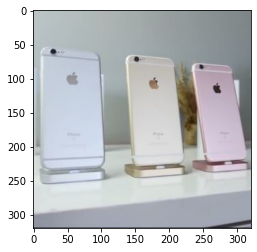

In [31]:
plt.figure()
plt.imshow(img)

In [32]:
val_datagen.flow(cv2.resize(img,(224,224))[None,:,:])

In [33]:
scores = product_model.predict(val_datagen.flow(cv2.resize(img,(224,224))[None,:,:]))
predicted_category = product_index_category[int(tf.argmax(scores,axis=1).numpy())]
print("Predicted category:", predicted_category)

Predicted category: DIENTHOAI


In [34]:
data['predicted_category'] = predicted_category

# Sold Prediction

In [35]:
item_df = pd.read_csv("data/items.csv",encoding='utf-8', delimiter="\t")
search_df = pd.read_csv("data/search_15k6.csv",encoding='utf-8', delimiter="\t")
#Convert shop_rate_feedback and shop_time_feedback's None values to zeros

item_df[['shop_rate_feedback']] = item_df[['shop_rate_feedback']].replace("None", 0).astype(int)
item_df[['shop_time_feedback']] = item_df[['shop_time_feedback']].replace("None", 0).astype(int)

full_df = search_df.merge(item_df, how='inner', on=['id'], suffixes=(None,'_2'))

In [36]:
#category: categorical
#price: numerical
#shop_address: categorical
#avg_rating: numerical
#n_reviews: numerical
#n_loved: numerical
#shop_n_review: numerical
#shop_n_product: numerical
#shop_rate_feedback: numerical 
#shop_time_feedback: numerical
#shop_age: numerical
#shop_follower: numerical

#Extract features
category = pd.get_dummies(full_df['category'], drop_first=True) #Convert category to one hot encoding
price = full_df[['price']]
shop_address = pd.get_dummies(full_df['shop_address'], drop_first=True)
avg_rating = full_df[['avg_rating']]
n_reviews = full_df[['n_reviews']]
n_loved = full_df[['n_loved']]
shop_n_review = full_df[['shop_n_review']]
shop_n_product = full_df[['shop_n_product']]
shop_rate_feedback = full_df[['shop_rate_feedback']]
shop_time_feedback = full_df[['shop_time_feedback']]
shop_age = full_df[['shop_age']]
shop_follower = full_df[['shop_follower']]


In [37]:
feature_list = [shop_address, 
                category, 
                price,

                avg_rating, 
                n_reviews, 
                n_loved, 

                shop_n_review, 
                shop_n_product, 
                shop_rate_feedback, 
                shop_time_feedback, 
                shop_age, 
                shop_follower
                ]

In [38]:
X = np.hstack(feature_list)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=1)
X_train, X_val = train_test_split(X_train , test_size=0.2, random_state=1)

In [39]:
#perform feature scaling
normalizer = StandardScaler()

X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

In [40]:
category_to_index = {cat:i for i, cat in enumerate(category.columns.to_numpy())}
shop_address_to_index = {addr:i for i, addr in enumerate(shop_address.columns.to_numpy())}

In [41]:
def transform_onehot(str_value, convert_dict): #convert a category string value into onehot vector using convert_dict to look up
    #e.g. 'DIENTHOAI' => [0,0,1,0,....,0]
    res = np.zeros(len(convert_dict))
    if str_value in convert_dict.keys():
        res[convert_dict[str_value]] = 1
    return res


In [42]:
transform_onehot("Bình Dương",shop_address_to_index)

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [43]:
data['shop_address'] = 'TP. Hồ Chí Minh'

In [44]:
transform_onehot(data['predicted_category'], category_to_index), data['avg_rating']

(array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 4.828571428571428)

In [45]:
x = np.hstack([transform_onehot(data['shop_address'],shop_address_to_index), 
     transform_onehot(data['predicted_category'], category_to_index), 
     data['price'],
     data['avg_rating'], 
     data['n_reviews'], 
     data['n_loved'], 
     data['shop_n_review'], 
     data['shop_n_product'], 
     data['shop_rate_feedback'], 
     data['shop_time_feedback'], 
     data['shop_age'], 
     data['shop_follower']])

In [46]:
x = normalizer.transform(x[None,:])

In [47]:
sold_model = tf.keras.models.Sequential([
    tf.keras.layers.Input((82,)),
    tf.keras.layers.Dense(units=32,activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(units=64, activation ='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(units=1, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))
])

sold_model.load_weights("models/sold_prediction_nn_model.h5")

In [48]:
predicted_n_sold = sold_model(x)
print("Sold predicted value:",predicted_n_sold.numpy().squeeze())

Sold predicted value: 903.15656
